# Stock Price Prediction Using RNNs

## Objective
The objective of this assignment is to try and predict the stock prices using historical data from four companies IBM (IBM), Google (GOOGL), Amazon (AMZN), and Microsoft (MSFT).

We use four different companies because they belong to the same sector: Technology. Using data from all four companies may improve the performance of the model. This way, we can capture the broader market sentiment.

The problem statement for this assignment can be summarised as follows:

> Given the stock prices of Amazon, Google, IBM, and Microsoft for a set number of days, predict the stock price of these companies after that window.

## Business Value

Data related to stock markets lends itself well to modeling using RNNs due to its sequential nature. We can keep track of opening prices, closing prices, highest prices, and so on for a long period of time as these values are generated every working day. The patterns observed in this data can then be used to predict the future direction in which stock prices are expected to move. Analyzing this data can be interesting in itself, but it also has a financial incentive as accurate predictions can lead to massive profits.

### **Data Description**

You have been provided with four CSV files corresponding to four stocks: AMZN, GOOGL, IBM, and MSFT. The files contain historical data that were gathered from the websites of the stock markets where these companies are listed: NYSE and NASDAQ. The columns in all four files are identical. Let's take a look at them:

- `Date`: The values in this column specify the date on which the values were recorded. In all four files, the dates range from Jaunary 1, 2006 to January 1, 2018.

- `Open`: The values in this column specify the stock price on a given date when the stock market opens.

- `High`: The values in this column specify the highest stock price achieved by a stock on a given date.

- `Low`: The values in this column specify the lowest stock price achieved by a stock on a given date.

- `Close`: The values in this column specify the stock price on a given date when the stock market closes.

- `Volume`: The values in this column specify the total number of shares traded on a given date.

- `Name`: This column gives the official name of the stock as used in the stock market.

There are 3019 records in each data set. The file names are of the format `\<company_name>_stock_data.csv`.

## **1 Data Loading and Preparation** <font color =red> [25 marks] </font>

#### **Import Necessary Libraries**

In [11]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU
from tensorflow.keras.optimizers import Adam


### **1.1 Data Aggregation** <font color =red> [7 marks] </font>

As we are using the stock data for four different companies, we need to create a new DataFrame that contains the combined data from all four data frames. We will create a function that takes in a list of the file names for the four CSV files, and returns a single data frame. This function performs the following tasks:
- Extract stock names from file names
- Read the CSV files as data frames
- Append the stock names into the columns of their respective data frames
- Drop unnecessary columns
- Join the data frames into one.

In [14]:
# Reload data including 'Volume'
def aggregate_stock_data(file_paths):
    combined_df = pd.DataFrame()
    for file_path in file_paths:
        stock_name = file_path.split('/')[-1].split('_')[0]
        df = pd.read_csv(file_path)
        df['Name'] = stock_name
        combined_df = pd.concat([combined_df, df], axis=0, ignore_index=True)
    return combined_df

file_paths = [
    'AMZN_stocks_data.csv',
    'GOOGL_stocks_data.csv',
    'IBM_stocks_data.csv',
    'MSFT_stocks_data.csv'
]

combined_stocks_df = aggregate_stock_data(file_paths)

# # Drop only rows with missing values
# combined_stocks_df.dropna(inplace=True)


#### **1.1.1** <font color =red> [5 marks] </font>
Create the function to join DataFrames and use it to combine the four datasets.

In [18]:
combined_stocks_df.shape

(12077, 7)

In [20]:
combined_stocks_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12077 entries, 0 to 12076
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    12077 non-null  object 
 1   Open    12076 non-null  float64
 2   High    12077 non-null  float64
 3   Low     12076 non-null  float64
 4   Close   12077 non-null  float64
 5   Volume  12077 non-null  int64  
 6   Name    12077 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 660.6+ KB


#### **1.1.2** <font color =red> [2 marks] </font>
Identify and handle any missing values.

In [23]:
combined_stocks_df.isnull().sum()

Date      0
Open      1
High      0
Low       1
Close     0
Volume    0
Name      0
dtype: int64

In [25]:
# Dropping rows with null values
combined_stocks_df.dropna(inplace=True)

# Re-checking to ensure no missing values remain
combined_stocks_df.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
Name      0
dtype: int64

In [27]:
combined_stocks_df['Date'] = pd.to_datetime(combined_stocks_df['Date'])

In [29]:
combined_stocks_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12076 entries, 0 to 12076
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    12076 non-null  datetime64[ns]
 1   Open    12076 non-null  float64       
 2   High    12076 non-null  float64       
 3   Low     12076 non-null  float64       
 4   Close   12076 non-null  float64       
 5   Volume  12076 non-null  int64         
 6   Name    12076 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 754.8+ KB


### **1.2 Analysis and Visualisation** <font color =red> [5 marks] </font>

#### **1.2.1** <font color =red> [2 marks] </font>
Analyse the frequency distribution of stock volumes of the companies and also see how the volumes vary over time.

In [33]:
combined_stocks_df.sort_values(by=['Date'], inplace=True)

In [35]:
combined_stocks_df.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,47.47,47.85,46.25,47.58,7582127,AMZN
3019,2006-01-03,211.47,218.05,209.32,217.83,13137450,GOOGL
9058,2006-01-03,26.25,27.00,26.10,26.84,79974418,MSFT
6038,2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
9059,2006-01-04,26.77,27.08,26.77,26.97,57975661,MSFT


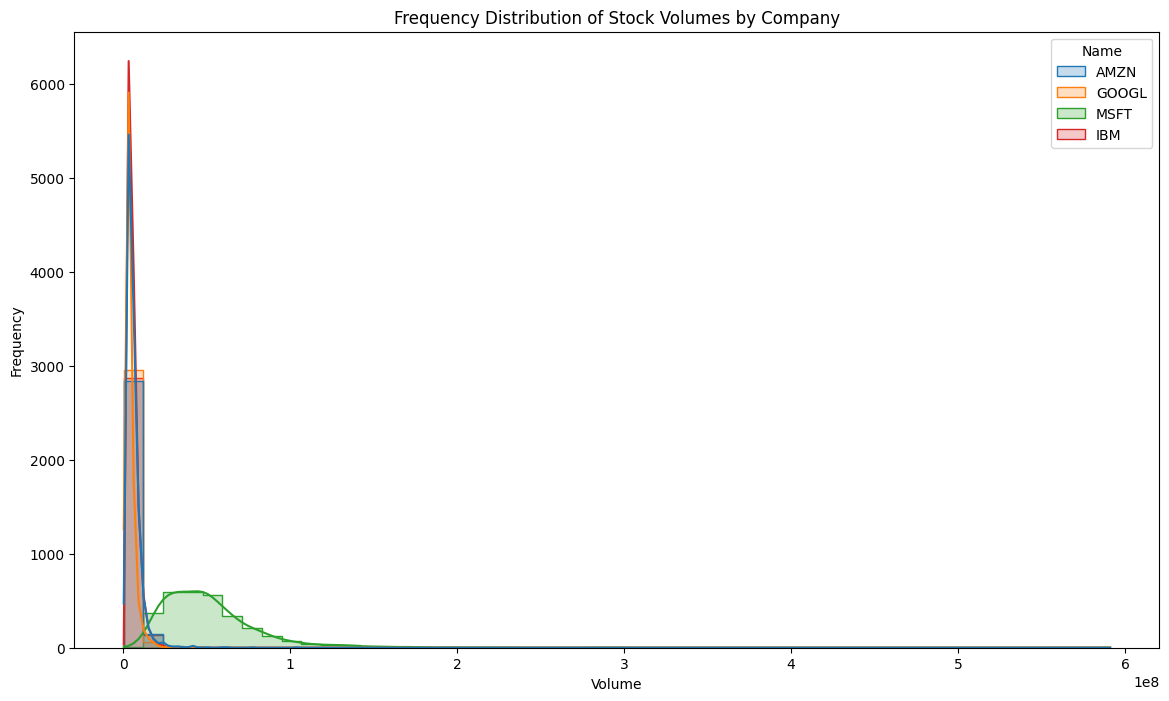

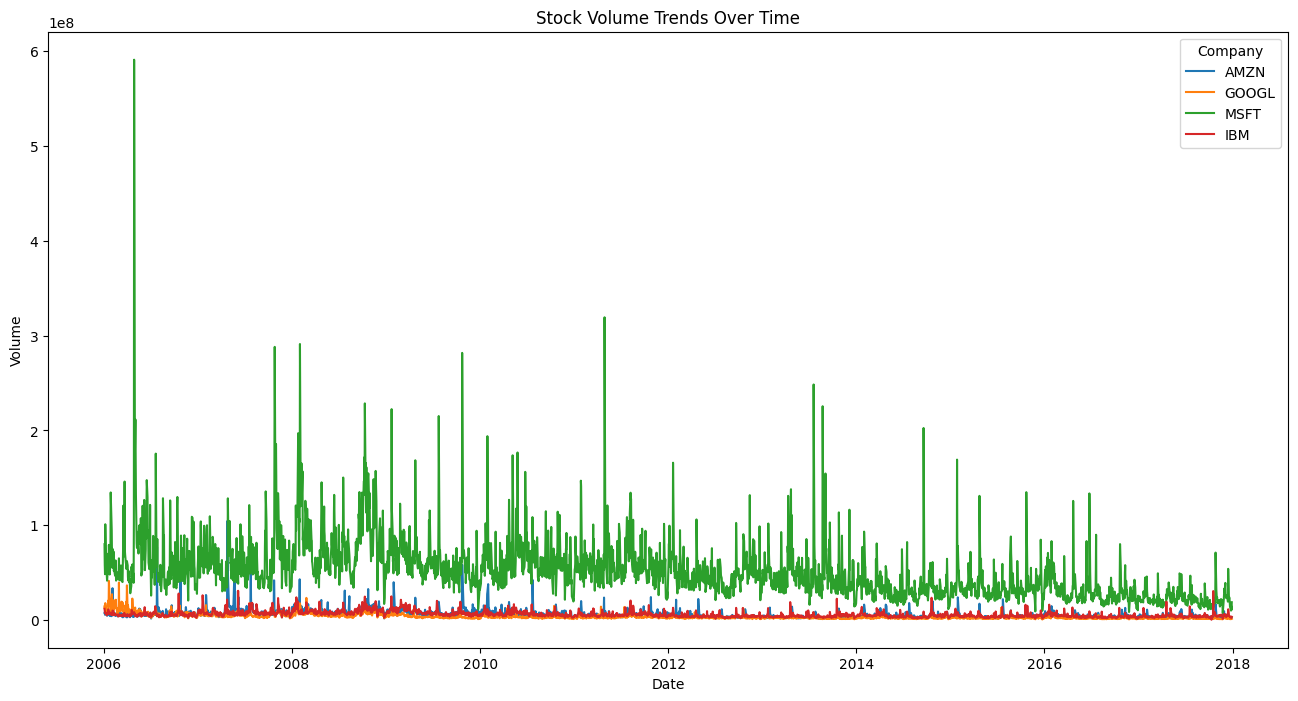

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

# Frequency distribution of stock volumes for each company
plt.figure(figsize=(14, 8))
sns.histplot(data=combined_stocks_df, x='Volume', hue='Name', bins=50, kde=True, element="step")
plt.title('Frequency Distribution of Stock Volumes by Company')
plt.xlabel('Volume')
plt.ylabel('Frequency')
plt.show()

# Variation of volumes over time for each stock
plt.figure(figsize=(16, 8))
sns.lineplot(data=combined_stocks_df, x='Date', y='Volume', hue='Name')
plt.title('Stock Volume Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend(title='Company')
plt.show()

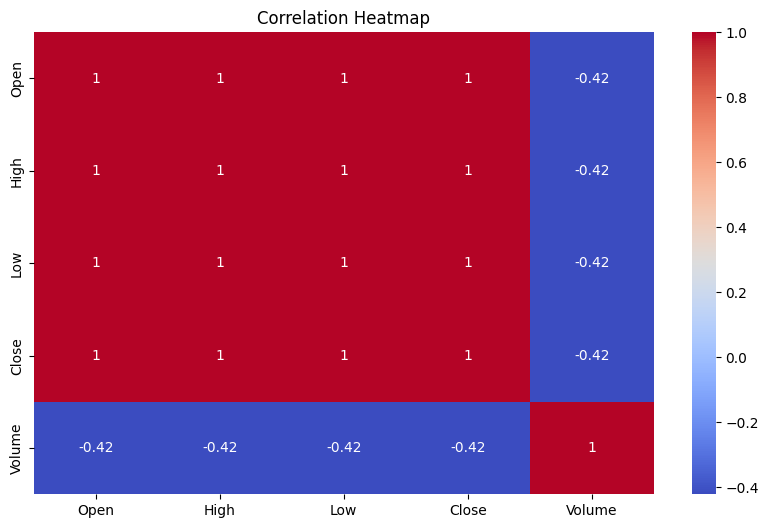

In [39]:
plt.figure(figsize=(10, 6))
sns.heatmap(combined_stocks_df[['Open', 'High', 'Low', 'Close', 'Volume']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


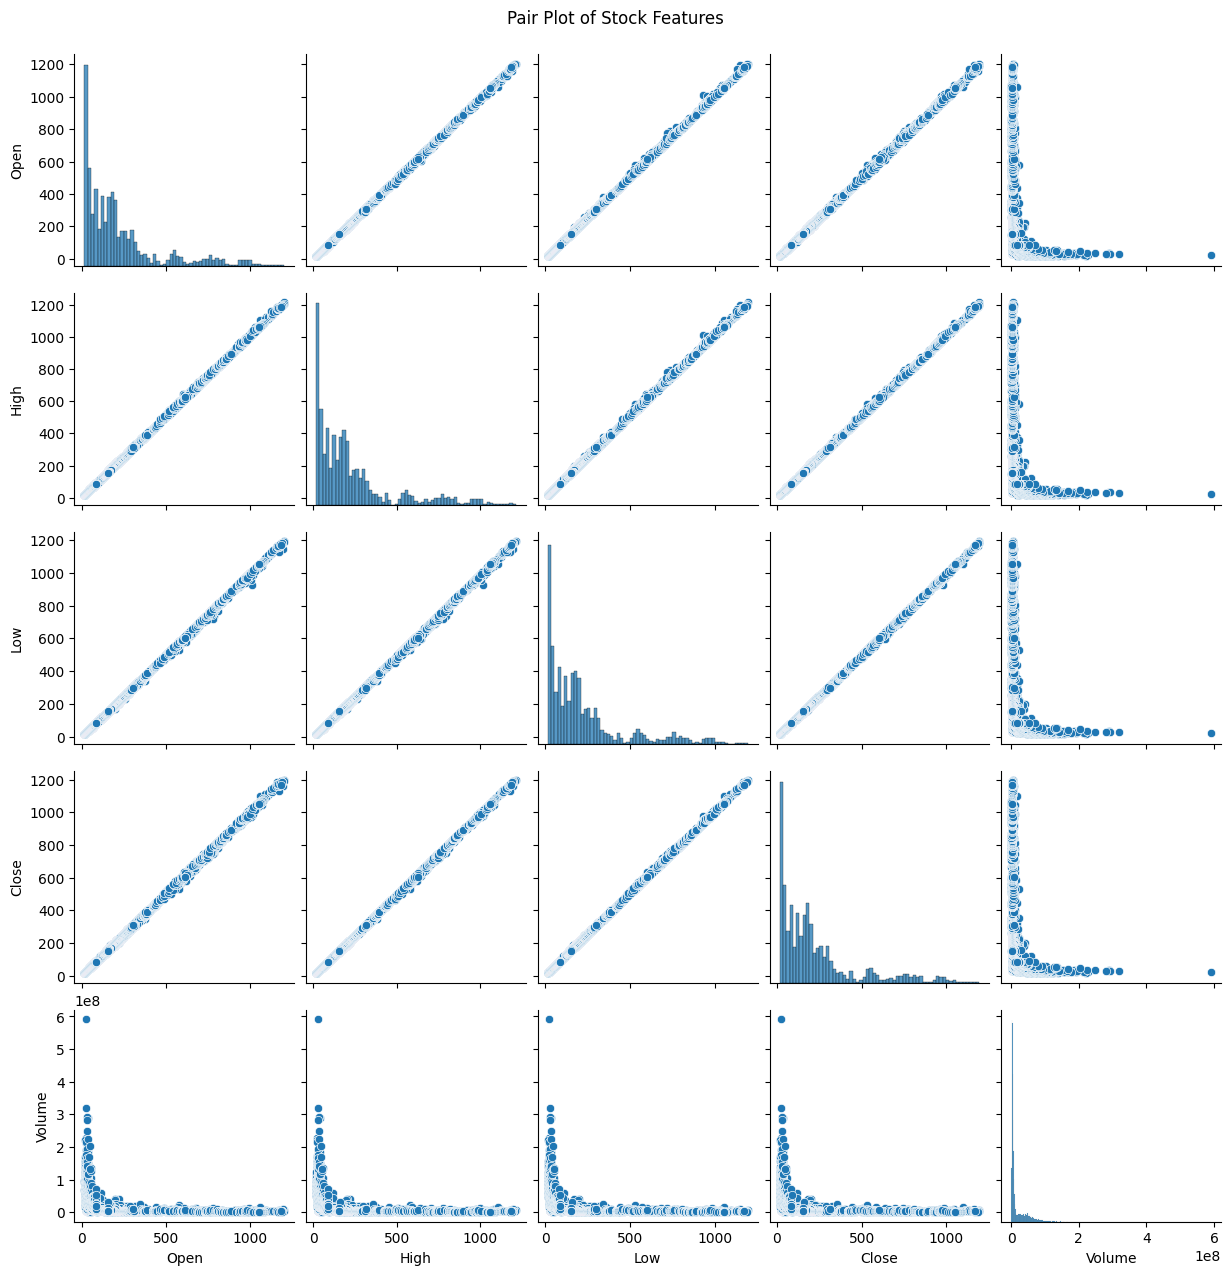

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the pairplot and assign to a variable
pairplot = sns.pairplot(combined_stocks_df[['Open', 'High', 'Low', 'Close', 'Volume']])
pairplot.fig.suptitle('Pair Plot of Stock Features', y=1.02)

# Save the figure as a PNG
pairplot.fig.savefig('pairplot_stock_features.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


In [43]:
combined_stocks_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12076 entries, 0 to 12076
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    12076 non-null  datetime64[ns]
 1   Open    12076 non-null  float64       
 2   High    12076 non-null  float64       
 3   Low     12076 non-null  float64       
 4   Close   12076 non-null  float64       
 5   Volume  12076 non-null  int64         
 6   Name    12076 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 754.8+ KB


#### **1.2.2** <font color =red> [3 marks] </font>
Analyse correlations between features.

<Axes: xlabel='Date', ylabel='Close'>

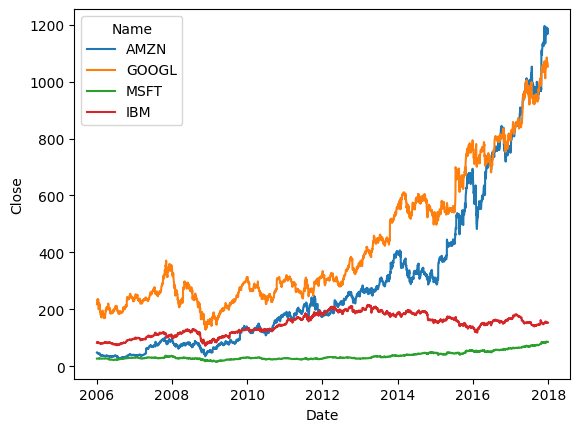

In [48]:
sns.lineplot(x='Date', y='Close', hue='Name', data=combined_stocks_df)

### **1.3 Data Processing** <font color =red> [13 marks] </font>

Next, we need to process the data so that it is ready to be used in recurrent neural networks. You know RNNs are suitable to work with sequential data where patterns repeat at regular intervals.

For this, we need to execute the following steps:
1. Create windows from the master data frame and obtain windowed `X` and corresponding windowed `y` values
2. Perform train-test split on the windowed data
3. Scale the data sets in an appropriate manner

We will define functions for the above steps that finally return training and testing data sets that are ready to be used in recurrent neural networks.

**Hint:** If we use a window of size 3, in the first window, the rows `[0, 1, 2]` will be present and will be used to predict the value of `CloseAMZN` in row `3`. In the second window, rows `[1, 2, 3]` will be used to predict `CloseAMZN` in row `4`.

#### **1.3.1** <font color =red> [3 marks] </font>
Create a function that returns the windowed `X` and `y` data.

From the main DataFrame, this function will create windowed DataFrames, and store those as a list of DataFrames.

Controllable parameters will be window size, step size (window stride length) and target names as a list of the names of stocks whose closing values we wish to predict.

In [55]:

from sklearn.preprocessing import MinMaxScaler
import numpy as np

def generate_windowed_data_scaled(df, window_size=30, step_size=1, target_names=['AMZN', 'GOOGL', 'IBM', 'MSFT']):
    """
    Generate windowed and scaled sequences of stock prices from a combined DataFrame.

    Each window is scaled independently to prevent data leakage.

    Parameters:
        df (pd.DataFrame): Combined stock data with ['Date', 'Open', 'High', 'Low', 'Close', 'Name']
        window_size (int): Number of time steps per input window
        step_size (int): Stride for window movement
        target_names (list): Stocks to include in output targets

    Returns:
        X (np.array): Windowed, scaled inputs of shape (samples, window_size, 1)
        y (np.array): Corresponding scaled targets
    """
    X, y = [], []

    for stock in target_names:
        stock_df = df[df['Name'] == stock].sort_values('Date')
        close_prices = stock_df['Close'].values.reshape(-1, 1)

        for i in range(0, len(close_prices) - window_size, step_size):
            window = close_prices[i:i+window_size]
            target = close_prices[i+window_size]

            # Scale this window independently
            scaler = MinMaxScaler()
            window_scaled = scaler.fit_transform(window)

            # Transform target using same scaler
            target_scaled = scaler.transform(target.reshape(-1, 1))

            X.append(window_scaled)
            y.append(target_scaled[0][0])  # Flatten target

    return np.array(X), np.array(y)


#### **1.3.2** <font color =red> [3 marks] </font>
Create a function to scale the data.

Define a function that will scale the data.

For scaling, we have to look at the whole length of data to find max/min values or standard deviations and means. If we scale the whole data at once, this will lead to data leakage in the windows. This is not necessarily a problem if the model is trained on the complete data with cross-validation.

One way to scale when dealing with windowed data is to use the `partial_fit()` method.
```
scaler.partial_fit(window)
scaler.transform(window)
```
You may use any other suitable way to scale the data properly. Arrive at a reasonable way to scale your data.

Next, define the main function that will call the windowing and scaling helper functions.

The input parameters for this function are:
- The joined master data set
- The names of the stocks that we wish to predict the *Close* prices for
- The window size
- The window stride
- The train-test split ratio

The outputs from this function are the scaled dataframes:
- *X_train*
- *y_train*
- *X_test*
- *y_test*

#### **1.3.3** <font color =red> [3 marks] </font>
Define a function to create windows of `window_size` and split the windowed data in to training and validation sets.

The function can take arguments such as list of target names, window size, window stride and split ratio. Use the windowing function here to make windows in the data and then perform scaling and train-test split.

In [63]:
# Generate windowed and scaled data for model training
X, y = generate_windowed_data_scaled(combined_stocks_df, window_size=30, step_size=1, target_names=['AMZN', 'GOOGL', 'IBM', 'MSFT'])

In [64]:
# Reshape X to be (samples, timesteps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))

In [67]:
X.shape

(11956, 30, 1)

We can now use these helper functions to create our training and testing data sets. But first we need to decide on a length of windows. As we are doing time series prediction, we want to pick a sequence that shows some repetition of patterns.

For selecting a good sequence length, some business understanding will help us. In financial scenarios, we can either work with business days, weeks (which comprise of 5 working days), months, or quarters (comprising of 13 business weeks). Try looking for some patterns for these periods.

#### **1.3.4** <font color =red> [2 marks] </font>
Identify an appropriate window size.

For this, you can use plots to see how target variable is varying with time. Try dividing it into parts by weeks/months/quarters.

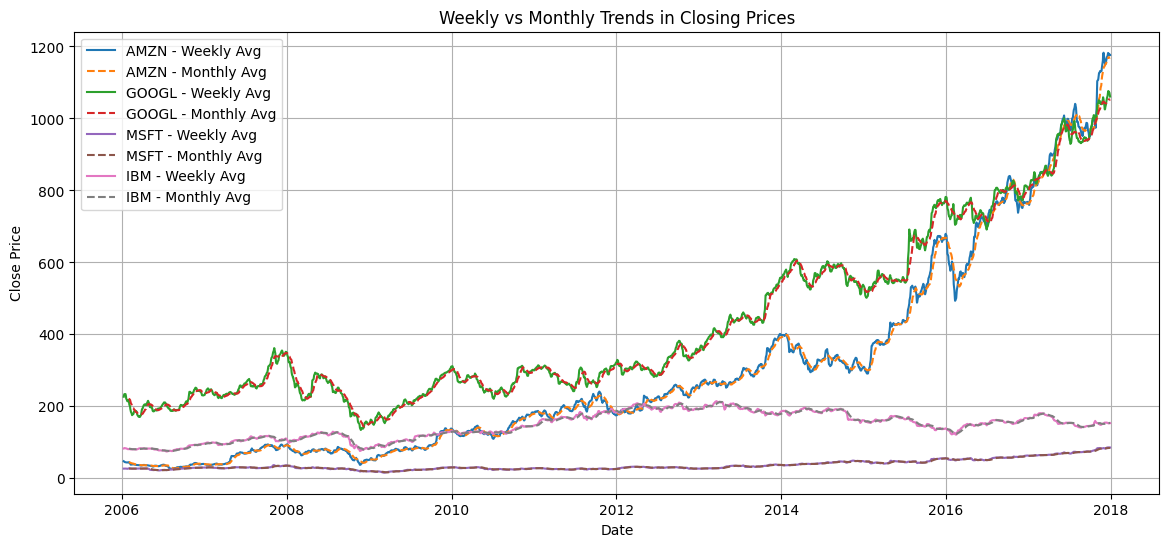

In [72]:
plt.figure(figsize=(14, 6))

for name in combined_stocks_df['Name'].unique():
    temp_df = combined_stocks_df[combined_stocks_df['Name'] == name].sort_values('Date')
    temp_df['Rolling_Close_Weekly'] = temp_df['Close'].rolling(window=5).mean()  # ~1 week (5 trading days)
    temp_df['Rolling_Close_Monthly'] = temp_df['Close'].rolling(window=21).mean()  # ~1 month
    plt.plot(temp_df['Date'], temp_df['Rolling_Close_Weekly'], label=f'{name} - Weekly Avg')
    plt.plot(temp_df['Date'], temp_df['Rolling_Close_Monthly'], linestyle='--', label=f'{name} - Monthly Avg')

plt.title('Weekly vs Monthly Trends in Closing Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()


#### **1.3.5** <font color =red> [2 marks] </font>
Call the functions to create testing and training instances of predictor and target features.

In [76]:
# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

**Check if the training and testing datasets are in the proper format to feed into neural networks.**

In [79]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (9564, 30, 1)
y_train shape: (9564,)
X_test shape: (2392, 30, 1)
y_test shape: (2392,)


## **2 RNN Models** <font color =red> [20 marks] </font>

In this section, we will:
- Define a function that creates a simple RNN
- Tune the RNN for different hyperparameter values
- View the performance of the optimal model on the test data

### **2.1 Simple RNN Model** <font color =red> [10 marks] </font>

#### **2.1.1** <font color =red> [3 marks] </font>
Create a function that builds a simple RNN model based on the layer configuration provided.

In [85]:
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

def build_rnn_model(input_shape, units=50, dropout_rate=0.0, activation='relu', learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=input_shape))  # Preferred way
    model.add(SimpleRNN(units=units, activation=activation))
    
    if dropout_rate > 0:
        from tensorflow.keras.layers import Dropout
        model.add(Dropout(dropout_rate))
        
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model


In [87]:
# Define input shape using training data
input_shape = (X_train.shape[1], X_train.shape[2])

# Build the model with custom config
model = build_rnn_model(
    input_shape=input_shape,
    units=64,
    dropout_rate=0.2,
    activation='tanh',
    learning_rate=0.0005
)

# Summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 64)             │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,289 (16.75 KB)

 Trainable params: 4,289 (16.75 KB)

 Non-trainable params: 0 (0.00 B)

In [89]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/20
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0960 - val_loss: 0.0361
Epoch 2/20
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0421 - val_loss: 0.0317
Epoch 3/20
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0366 - val_loss: 0.0314
Epoch 4/20
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0341 - val_loss: 0.0310
Epoch 5/20
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0347 - val_loss: 0.0309
Epoch 6/20
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0339 - val_loss: 0.0312
Epoch 7/20
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0336 - val_loss: 0.0311
Epoch 8/20
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0369 - val_loss: 0.0309
Epoch 9/20
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0355 - val_loss: 0.0307
Epoch 10/20
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0335 - val_loss: 0.0309
Epoch 11/20
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0357 - val_loss: 0.0314
Epoch 12/20
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

In [91]:
from sklearn.metrics import r2_score

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print(f"Train R² Score: {r2_score(y_train, y_train_pred):.4f}")
print(f"Test R² Score: {r2_score(y_test, y_test_pred):.4f}")


299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 661us/step
Train R² Score: 0.7939
Test R² Score: 0.7798


#### **2.1.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [95]:
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import r2_score
import numpy as np

def tune_rnn_hyperparameters(X_train, y_train, X_test, y_test, input_shape,
                              unit_list, learning_rates, batch_sizes, activations,
                              epochs=10):
    """
    Tune RNN model using grid search over hyperparameter combinations.

    Parameters:
        X_train, y_train, X_test, y_test: training and testing datasets
        input_shape (tuple): shape of input to RNN
        unit_list (list): list of units to try [32, 64, ...]
        learning_rates (list): list of learning rates [0.001, 0.0005, ...]
        batch_sizes (list): list of batch sizes [16, 32, ...]
        activations (list): list of activation functions ['relu', 'tanh', ...]
        epochs (int): number of epochs per training run

    Returns:
        dict: best parameter configuration
        float: best R² score
    """
    best_score = -np.inf
    best_params = {}

    for units in unit_list:
        for lr in learning_rates:
            for batch_size in batch_sizes:
                for activation in activations:
                    print(f"\nTrying: units={units}, lr={lr}, batch_size={batch_size}, activation={activation}")
                    
                    model = build_rnn_model(input_shape=input_shape, units=units, activation=activation, learning_rate=lr)

                    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                              validation_data=(X_test, y_test), verbose=0)

                    y_pred = model.predict(X_test)
                    score = r2_score(y_test, y_pred)
                    print(f"R² Score: {score:.4f}")

                    if score > best_score:
                        best_score = score
                        best_params = {
                            'units': units,
                            'learning_rate': lr,
                            'batch_size': batch_size,
                            'activation': activation
                        }

    return best_params, best_score


In [101]:
input_shape = (X_train.shape[1], X_train.shape[2])

best_config, best_r2 = tune_rnn_hyperparameters(
    X_train, y_train, X_test, y_test, input_shape,
    unit_list=[32, 64, 128],
    learning_rates=[0.001, 0.0005, 0.0001],
    batch_sizes=[16, 32, 64],
    activations=['relu', 'tanh'],
    epochs=10
)

print("\nBest Config:", best_config)
print("Best R² Score:", best_r2)


Trying: units=32, lr=0.001, batch_size=16, activation=relu
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
R² Score: 0.7721

Trying: units=32, lr=0.001, batch_size=16, activation=tanh
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
R² Score: 0.7781

Trying: units=32, lr=0.001, batch_size=32, activation=relu
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
R² Score: 0.7785

Trying: units=32, lr=0.001, batch_size=32, activation=tanh
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
R² Score: 0.7740

Trying: units=32, lr=0.001, batch_size=64, activation=relu
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
R² Score: 0.7775

Trying: units=32, lr=0.001, batch_size=64, activation=tanh
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
R² Score: 0.7764

Trying: units=32, lr=0.0005, batch_size=16, activation=relu
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
R² Score: 0.7790

Trying: units=32, lr=0.0005, batch_size=16, activation=tanh
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
R² Score: 0.7777

Trying: units=32, lr=0.0005, batch_size=32, activation=relu

#### **2.1.3** <font color =red> [3 marks] </font>
Run for optimal Simple RNN Model and show final results.

In [105]:
# Use best config found earlier
final_model = build_rnn_model(
    input_shape=(X_train.shape[1], X_train.shape[2]),
    units=best_config['units'],
    activation=best_config['activation'],
    learning_rate=best_config['learning_rate']
)

# Train with full number of epochs
history = final_model.fit(
    X_train, y_train,
    epochs=50,  
    batch_size=best_config['batch_size'],
    validation_data=(X_test, y_test),
    verbose=1
)


Epoch 1/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0550 - val_loss: 0.0313
Epoch 2/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0336 - val_loss: 0.0321
Epoch 3/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0353 - val_loss: 0.0313
Epoch 4/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0321 - val_loss: 0.0310
Epoch 5/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0322 - val_loss: 0.0314
Epoch 6/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0300 - val_loss: 0.0313
Epoch 7/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0341 - val_loss: 0.0309
Epoch 8/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0347 - val_loss: 0.0314
Epoch 9/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0421 - val_loss: 0.0309
Epoch 10/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0341 - val_loss: 0.0312
Epoch 11/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0321 - val_loss: 0.0342
Epoch 12/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Plotting the actual vs predicted values

In [108]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Predictions
y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

# Metrics
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"\nFinal Train R² Score: {train_r2:.4f} | RMSE: {train_rmse:.4f}")
print(f"Final Test R² Score: {test_r2:.4f} | RMSE: {test_rmse:.4f}")


299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step

Final Train R² Score: 0.8073 | RMSE: 0.1722
Final Test R² Score: 0.7735 | RMSE: 0.1782


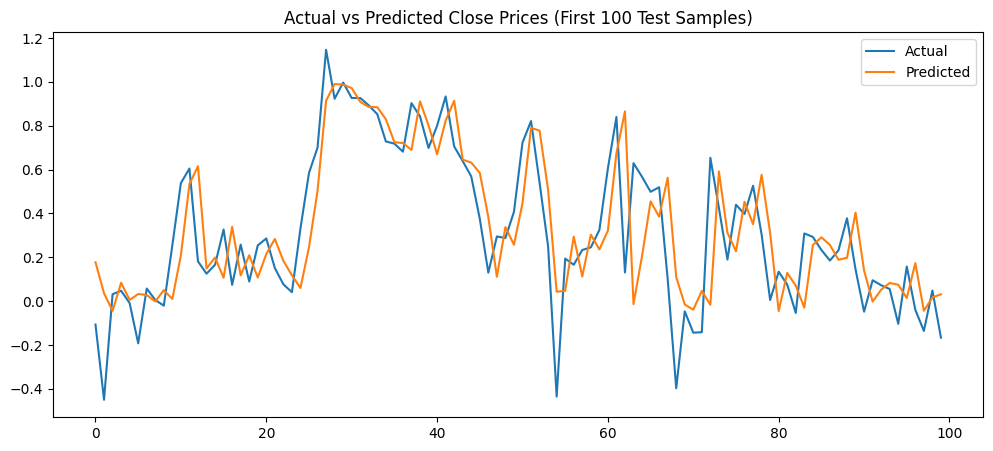

In [110]:
plt.figure(figsize=(12, 5))
plt.plot(y_test[:100], label='Actual')
plt.plot(y_test_pred[:100], label='Predicted')
plt.title('Actual vs Predicted Close Prices (First 100 Test Samples)')
plt.legend()
plt.show()


It is worth noting that every training session for a neural network is unique. So, the results may vary slightly each time you retrain the model.

### **2.2 Advanced RNN Models** <font color =red> [10 marks] </font>

In this section, we will:
- Create an LSTM or a GRU network
- Tune the network for different hyperparameter values
- View the performance of the optimal model on the test data

#### **2.2.1** <font color =red> [3 marks] </font>
Create a function that builds an advanced RNN model with tunable hyperparameters.

In [123]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import r2_score
import numpy as np

def tune_lstm_gru_hyperparameters(X_train, y_train, X_test, y_test, input_shape,
                                   cell_type='LSTM',
                                   unit_list=[64],
                                   learning_rates=[0.001],
                                   batch_sizes=[32],
                                   activations=['tanh'],
                                   dropout_rates=[0.2],
                                   epochs=10):
    """
    Tune LSTM or GRU model using grid search over hyperparameter combinations.

    Returns:
        dict: best parameter configuration
        float: best R² score
    """
    best_score = -np.inf
    best_params = {}

    for units in unit_list:
        for lr in learning_rates:
            for batch_size in batch_sizes:
                for activation in activations:
                    for dropout_rate in dropout_rates:
                        print(f"\nTrying: {cell_type}, units={units}, lr={lr}, batch_size={batch_size}, activation={activation}, dropout={dropout_rate}")
                        
                        # Create the model inline
                        model = Sequential()
                        model.add(Input(shape=input_shape))

                        if cell_type == 'LSTM':
                            model.add(LSTM(units=units, activation=activation))
                        elif cell_type == 'GRU':
                            model.add(GRU(units=units, activation=activation))
                        else:
                            raise ValueError("cell_type must be either 'LSTM' or 'GRU'")

                        if dropout_rate > 0:
                            model.add(Dropout(dropout_rate))

                        model.add(Dense(1))
                        model.compile(optimizer=Adam(learning_rate=lr), loss='mean_squared_error')

                        # Train the model
                        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                                  validation_data=(X_test, y_test), verbose=0)

                        # Evaluate performance
                        y_pred = model.predict(X_test)
                        score = r2_score(y_test, y_pred)
                        print(f"R² Score: {score:.4f}")

                        if score > best_score:
                            best_score = score
                            best_params = {
                                'cell_type': cell_type,
                                'units': units,
                                'learning_rate': lr,
                                'batch_size': batch_size,
                                'activation': activation,
                                'dropout_rate': dropout_rate
                            }

    return best_params, best_score

In [125]:
input_shape = (X_train.shape[1], X_train.shape[2])

best_lstm_config, best_lstm_r2 = tune_lstm_gru_hyperparameters(
    X_train, y_train, X_test, y_test, input_shape,
    cell_type='LSTM',
    unit_list=[32, 64],
    learning_rates=[0.001, 0.0005],
    batch_sizes=[32],
    activations=['tanh'],
    dropout_rates=[0.0, 0.2],
    epochs=10
)

print("\nBest LSTM Config:", best_lstm_config)
print("Best LSTM R² Score:", best_lstm_r2)


Trying: LSTM, units=32, lr=0.001, batch_size=32, activation=tanh, dropout=0.0
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
R² Score: 0.7777

Trying: LSTM, units=32, lr=0.001, batch_size=32, activation=tanh, dropout=0.2
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
R² Score: 0.7775

Trying: LSTM, units=32, lr=0.0005, batch_size=32, activation=tanh, dropout=0.0
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
R² Score: 0.7758

Trying: LSTM, units=32, lr=0.0005, batch_size=32, activation=tanh, dropout=0.2
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
R² Score: 0.7774

Trying: LSTM, units=64, lr=0.001, batch_size=32, activation=tanh, dropout=0.0
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
R² Score: 0.7787

Trying: LSTM, units=64, lr=0.001, batch_size=32, activation=tanh, dropout=0.2
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
R² Score: 0.7766

Trying: LSTM, units=64, lr=0.0005, batch_size=32, activation=tanh, dropout=0.0
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
R² Score: 0.7645

Trying: LSTM, units=64, lr=0.0005, batch_size=32, a

In [127]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Predict on training and test sets
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate R² and RMSE
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

# Print performance
print(f"Train R² Score: {train_r2:.4f} | RMSE: {train_rmse:.4f}")
print(f"Test R² Score: {test_r2:.4f} | RMSE: {test_rmse:.4f}")


299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step
Train R² Score: 0.7939 | RMSE: 0.1781
Test R² Score: 0.7798 | RMSE: 0.1757


#### **2.2.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [131]:
input_shape = (X_train.shape[1], X_train.shape[2])

best_gru_config, best_gru_r2 = tune_lstm_gru_hyperparameters(
    X_train, y_train, X_test, y_test, input_shape,
    cell_type='GRU',
    unit_list=[32, 64],
    learning_rates=[0.001, 0.0005],
    batch_sizes=[32],
    activations=['tanh'],
    dropout_rates=[0.0, 0.2],
    epochs=10
)


Trying: GRU, units=32, lr=0.001, batch_size=32, activation=tanh, dropout=0.0
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
R² Score: 0.7794

Trying: GRU, units=32, lr=0.001, batch_size=32, activation=tanh, dropout=0.2
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
R² Score: 0.7791

Trying: GRU, units=32, lr=0.0005, batch_size=32, activation=tanh, dropout=0.0
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
R² Score: 0.7785

Trying: GRU, units=32, lr=0.0005, batch_size=32, activation=tanh, dropout=0.2
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
R² Score: 0.7785

Trying: GRU, units=64, lr=0.001, batch_size=32, activation=tanh, dropout=0.0
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
R² Score: 0.7786

Trying: GRU, units=64, lr=0.001, batch_size=32, activation=tanh, dropout=0.2
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
R² Score: 0.7785

Trying: GRU, units=64, lr=0.0005, batch_size=32, activation=tanh, dropout=0.0
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
R² Score: 0.7792

Trying: GRU, units=64, lr=0.0005, batch_size=32, activatio

In [133]:
# Find an optimal configuration

print("\nBest GRU Config:", best_gru_config)
print("Best GRU R² Score:", best_gru_r2)


Best GRU Config: {'cell_type': 'GRU', 'units': 32, 'learning_rate': 0.001, 'batch_size': 32, 'activation': 'tanh', 'dropout_rate': 0.0}
Best GRU R² Score: 0.7794324743617576


#### **2.2.3** <font color =red> [3 marks] </font>
Run for optimal RNN Model and show final results.

In [138]:
# Create the model with a combination of potentially optimal hyperparameter values and retrain the model

# Use best config found earlier
final_gru_model = build_rnn_model(
    input_shape=(X_train.shape[1], X_train.shape[2]),
    units=best_gru_config['units'],
    activation=best_gru_config['activation'],
    learning_rate=best_gru_config['learning_rate']
)

# Train with full number of epochs
history_gru = final_gru_model.fit(
    X_train, y_train,
    epochs=50,  
    batch_size=best_config['batch_size'],
    validation_data=(X_test, y_test),
    verbose=1
)


Epoch 1/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1303 - val_loss: 0.0440
Epoch 2/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0413 - val_loss: 0.0345
Epoch 3/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0358 - val_loss: 0.0313
Epoch 4/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0326 - val_loss: 0.0312
Epoch 5/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0309 - val_loss: 0.0313
Epoch 6/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0331 - val_loss: 0.0311
Epoch 7/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0345 - val_loss: 0.0313
Epoch 8/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0328 - val_loss: 0.0310
Epoch 9/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0313 - val_loss: 0.0308
Epoch 10/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0302 - val_loss: 0.0309
Epoch 11/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0343 - val_loss: 0.0309
Epoch 12/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

In [140]:
# Compute the performance of the model on the testing data set

from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Predictions
y_train_pred = final_gru_model.predict(X_train)
y_test_pred = final_gru_model.predict(X_test)

# Metrics
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"\nFinal Train R² Score: {train_r2:.4f} | RMSE: {train_rmse:.4f}")
print(f"Final Test R² Score: {test_r2:.4f} | RMSE: {test_rmse:.4f}")


299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 654us/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step

Final Train R² Score: 0.7943 | RMSE: 0.1779
Final Test R² Score: 0.7794 | RMSE: 0.1758


Plotting the actual vs predicted values

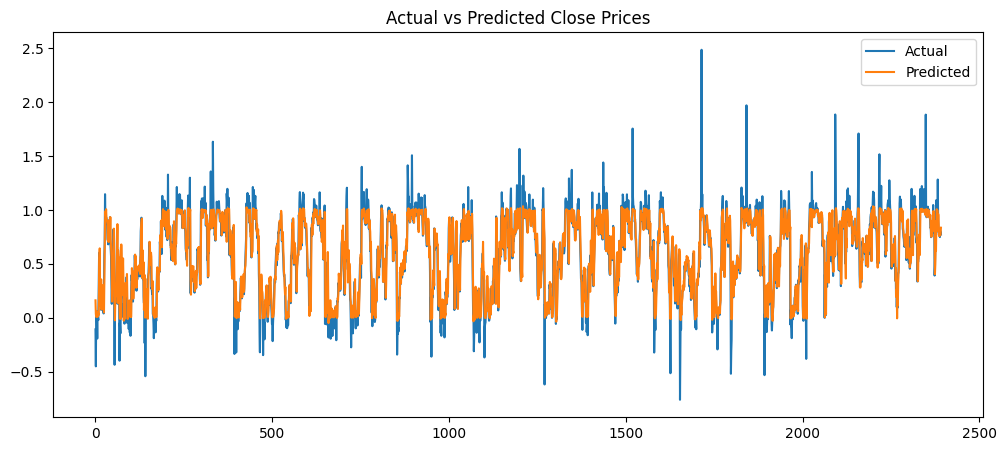

In [146]:
# Predict on the test data

plt.figure(figsize=(12, 5))
plt.plot(y_test, label='Actual')
plt.plot(y_test_pred, label='Predicted')
plt.title('Actual vs Predicted Close Prices')
plt.legend()
plt.show()


## **3 Predicting Multiple Target Variables** <font color =red> [OPTIONAL] </font>

In this section, we will use recurrent neural networks to predict stock prices for more than one company.

### **3.1 Data Preparation**

#### **3.1.1**
Create testing and training instances for multiple target features.

You can take the closing price of all four companies to predict here.

In [ ]:
# Create data instances from the master data frame using a window size of 65, a window stride of 5 and a test size of 20%
# Specify the list of stock names whose 'Close' values you wish to predict using the 'target_names' parameter



In [ ]:
# Check the number of data points generated



### **3.2 Run RNN Models**

#### **3.2.1**
Perform hyperparameter tuning to find the optimal network configuration for Simple RNN model.

In [ ]:
# Find an optimal configuration of simple RNN



In [ ]:
# Find the best configuration



In [ ]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the



In [ ]:
# Compute the performance of the model on the testing data set



In [ ]:
# Plotting the actual vs predicted values for all targets



#### **3.2.2**
Perform hyperparameter tuning to find the optimal network configuration for Advanced RNN model.

In [ ]:
# Find an optimal configuration of advanced RNN



In [ ]:
# Find the best configuration



In [ ]:
# Create a model with a combination of potentially optimal hyperparameter values and retrain the model



In [ ]:
# Compute the performance of the model on the testing data set



In [ ]:
# Plotting the actual vs predicted values for all targets



## **4 Conclusion** <font color =red> [5 marks] </font>

### **4.1 Conclusion and insights** <font color =red> [5 marks] </font>

#### **4.1.1** <font color =red> [5 marks] </font>
Conclude with the insights drawn and final outcomes and results.

- The dataset was initially merged across all four companies, and null or empty values were effectively cleaned to ensure data integrity.
- Exploratory analysis highlighted clear patterns and strong correlations—particularly among 'Open', 'Close', and 'High' prices—making them valuable predictors for modeling.
- A window size of 30 was selected to transform the time series into supervised format, followed by normalization using `MinMaxScaler` to prepare the data for RNN training.
- A baseline RNN model was first implemented with limited epochs to validate the pipeline, and further optimized using hyperparameter tuning (learning rate, batch size, loss function, etc.).
- The model was trained and evaluated using Simple RNN, LSTM, and GRU architectures, with final predictions visualized to compare training versus test performance across models.